**This notebook is an exercise in the [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/mutual-information).**

---


# 상호정보(Mutual Information)
- 새로운 데이터셋을 접할 때는 수백 개 또는 수천 개의 특성을 설명 없이 제시
- 특성 유틸리티 메트릭은 특성과 타겟 간의 관계를 측정하는 함수
- 특성 유틸리티 메트릭을 사용하여 순위를 매김

> 가장 유용한 특성들로 이루어진 작은 세트를 선택해 초기 개발을 진행

> Mutual Information, MI : 사용할 메트릭 

> 이는 모든 종류의 관계를 탐지할 수 있는 반면, 상관관계는 선형관계만 탐지할 수 있다


- 사용하기 쉽고 해석하기 쉬움
- 계산 효율적
- 이론적으로 잘 정립
- 과적합에 저항
- 어떤 종류의 관계도 탐지 가능

### ex)

각 ExterQual 범주는 SalePrice를 특정 범위 내로 집중시키는 경향이 있습니다. 

ExterQual과 SalePrice 간의 상호 정보는 ExterQual의 네 가지 값에 대해 SalePrice의 불확실성 감소의 평균입니다. 

예를 들어, Fair는 Typical보다 덜 자주 발생하므로, Fair는 MI 점수에서 더 적은 가중치를 받습니다.

# Introduction #

In this exercise you'll identify an initial set of features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset to develop using mutual information scores and interaction plots.

Run this cell to set everything up!

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex2 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Load data
df = pd.read_csv("../input/fe-course-data/ames.csv")


# Utility functions from Tutorial
# 상호정보 계산
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 상호정보 점수 표시
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

/tmp/ipykernel_34/2073615749.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


-------------------------------------------------------------------------------

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

In [ ]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);
# data=df.melt(id_vars="SalePrice", value_vars=features)
# >> df를 재구성하는 메소드
# id_vars="SalePrice": SalePrice 열을 기준으로 데이터를 정렬
# value_vars=features는 features 리스트에 포함된 열들만을 포함하도록 지정

# 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with `SalePrice`?

In [4]:
# View the solution (Run this cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Based on the plots, `YearBuilt` should have the highest MI score since knowing the year tends to constrain `SalePrice` to a smaller range of possible values. This is generally not the case for `MoSold`, however. Finally, since `ScreenPorch` is usually just one value, 0, on average it won't tell you much about `SalePrice` (though more than `MoSold`) .

-------------------------------------------------------------------------------

The *Ames* dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the `make_mi_scores` function (introduced in the tutorial) to compute mutual information scores for the *Ames* features:


In [8]:
X = df.copy()
y = X.pop('SalePrice')
# 타겟 변수 분리
# X에서 'SalePrice'라는 열을 제거하고 이를 변수 y에 할당하는 작업
# y는 주택 판매 가격을 담고 있는 시리즈

# X.pop('SalePrice')를 사용하면 데이터프레임 X에서 'SalePrice'라는 열을 제거

mi_scores = make_mi_scores(X, y)
# X와 타겟 변수 y에 대해 각 특성(feature)의 Mutual Information (상호 정보량) 점수를 계산하는 함수
# sklearn.feature_selection 모듈의 mutual_info_regression 함수를 사용하여 
# 연속형 변수에 대한 Mutual Information을 계산하고, 이를 시리즈(Series) 형태로 반환

Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


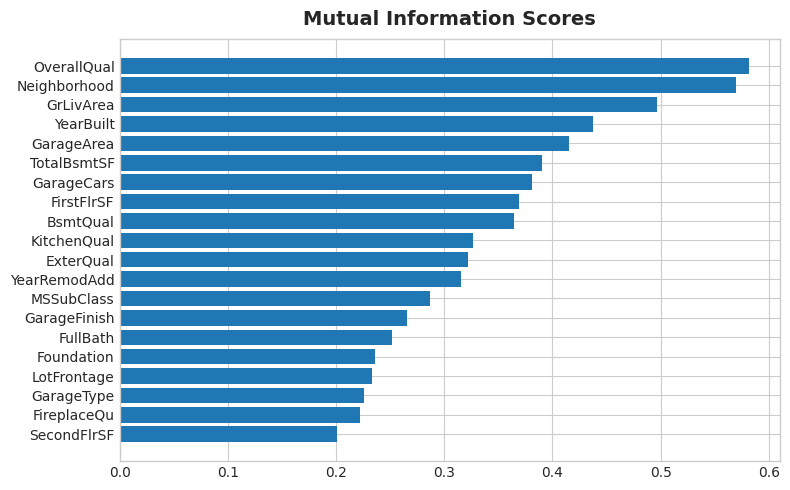

In [9]:
print(mi_scores.head(20))# mi_scores.head(20)를 통해 출력된 결과는 상호 정보량
# 상호 정보량(Mutual Information, MI) 점수가 높은 순서대로 상위 20개의 특성(feature)을 나열
# 각 특성이 타겟 변수(여기서는 'SalePrice')와 얼마나 유의미하게 관련되어 있는지
# 상호 정보량 점수가 높을수록 해당 특성이 타겟 변수를 예측하는 데 중요

#>> 상위 특성들은 초기 특성 선택이나 모델 개발 시 주요한 고려 대상이 됨

# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

# 2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe? 

In [10]:
# OverallQual (전체 품질), Neighborhood (동네),GrLivArea (지상 생활 면적),YearBuilt (건축 연도)
# 높은 점수를 받은 특성들은 대부분 사람들이 주택에서 중요하게 생각할만한 요소들 처럼 보인다
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

Some common themes among most of these features are:
- Location: `Neighborhood`
- Size: all of the `Area` and `SF` features, and counts like `FullBath` and `GarageCars`
- Quality: all of the `Qual` features
- Year: `YearBuilt` and `YearRemodAdd`
- Types: descriptions of features and styles like `Foundation` and `GarageType`

These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow), It's good then that our mutual information metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.


-------------------------------------------------------------------------------

In this step you'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>		
>       1Fam	Single-family Detached	
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

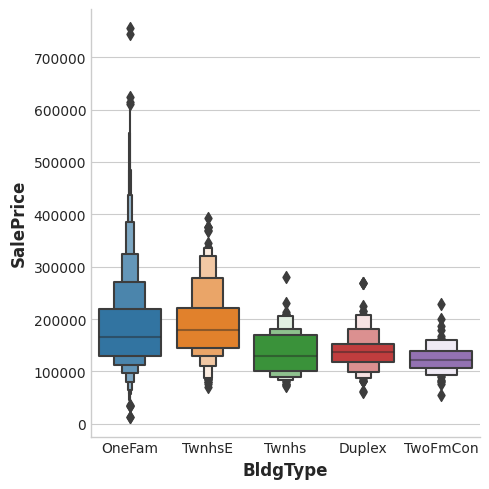

In [12]:
# 건물 유형에 대한 상호 작용 효과 >> 5가지 카테고리로 주거 구조 설명
# >> 상호 정보량(MI) 점수가 그리 높지 않음
# 플롯을 확인하면 BldgType의 카테고리가 SalePrice(판매 가격)의 값들을 잘 구별하지 못함

sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");
# sns.catplot: seaborn 라이브러리의 카테고리 플롯을 그리는 함수
# catplot은 기본적으로 kind="strip"로 설정되어 있으며, 다양한 종류의 카테고리 플롯을 생성
# kind="boxen": 그래프 종류 지정, "boxen"은 상자 그림을 확장한 형태로, 데이터의 분포를 상세히 보줌

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

In [ ]:
# YOUR CODE HERE: 
feature = "GrLivArea"
plt.figure(figsize =(12, 6))
sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);
plt.show()
# sns.lmplot: seaborn 라이브러리의 산점도와 선형 회귀 선을 함께 그리는 함수

<Figure size 1200x600 with 0 Axes>

The trend lines being significantly different from one category to the next indicates an interaction effect.

# 3) Discover Interactions

From the plots, does `BldgType` seem to exhibit an interaction effect with either `GrLivArea` or `MoSold`?

In [19]:
# View the solution (Run this cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The trends lines within each category of `BldgType` are clearly very different, indicating an interaction between these features. Since knowing `BldgType` tells us more about how `GrLivArea` relates to `SalePrice`, we should consider including `BldgType` in our feature set.

The trend lines for `MoSold`, however, are almost all the same. This feature hasn't become more informative for knowing `BldgType`.

# A First Set of Development Features #

Let's take a moment to make a list of features we might focus on. In the exercise in Lesson 3, you'll start to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [20]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.

# Keep Going #

[**Start creating features**](https://www.kaggle.com/ryanholbrook/creating-features) and learn what kinds of transformations different models are most likely to benefit from.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*